In [64]:
# Utilities
import os                          # Import operating system interface
import win32com.client as win32    # Import COM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna
import dill
import seaborn as sns
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice
from tqdm.notebook import tqdm

plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = [4, 4]  # Largo, ancho  
plt.rcParams["text.usetex"] = False
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import MultipleLocator
import seaborn as sns
#import dill
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Binary
from pymoo.algorithms.moo.nsga2 import NSGA2 #, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.termination import get_termination
from pymoo.termination.max_gen import MaximumGenerationTermination

# Optimization using NSGAII


In [ ]:

class DirectSequence(ElementwiseProblem):
    
    def __init__(self,listofcomponents,FlashPoint_val,IgnitionTemperature_val, NF, NR, listLFL , listUFL, tags, tags_1 , c1_mole_frac, 
        c2_mole_frac, c3_mole_frac,**kwargs):
        #Column 1: Number stages,Reflux ratio,Feed stage1,Feed stage2, SolventFlow
        #Column 2: Number stages,Reflux ratio,Feed stage
        
        self.listofcomponents = listofcomponents
        self.FlashPoint_val = FlashPoint_val
        self.IgnitionTemperature_val = IgnitionTemperature_val
        self.NF = NF
        self.NR = NR
        self.c1_mole_frac = c1_mole_frac
        self.c2_mole_frac = c2_mole_frac
        self.c3_mole_frac = c3_mole_frac

        variables = dict()
        # ------------------Bounds----------------------#
        # First column
        Max_NT_C1, Max_NT_C2 = 70 , 70
        Max_Rr_C1, Max_Rr_C2 = 7.0, 7.0 
        variables[f"x1"] = Integer(bounds=(2,Max_NT_C1))   #Number stage extractive
        variables[f'x2'] = Real(bounds=(0.1,Max_Rr_C1))    #Reflux ratio extractive
        variables[f'x3'] = Integer(bounds=(2,Max_NT_C1))    #Feed stage solvent
        variables[f'x4'] = Integer(bounds=(2,Max_NT_C1))    #Feed stage azeotropic
        variables[f'x5'] = Real(bounds=(5,500))      #Solvent flow
        # Second column
        variables[f'x6'] = Integer(bounds=(3,Max_NT_C2))   #Number stage 
        variables[f'x7'] = Real(bounds=(0.1,Max_Rr_C2))    #Reflux ratio 
        variables[f'x8'] = Integer(bounds=(2,Max_NT_C2))    #Feed stage 
        super().__init__(vars=variables, n_obj=4,n_ieq_constr=3, **kwargs)

    def Column(self, d, nt, P , payback = 3,M_S = 1716,fm = 3.67, ft = 0):
        # Inputs
        # M_S : M&S is Marshall and Swift Equipment Cost Index year 2019
        # fm value for stainless steel
        # d : column diameter in meters
        # nt : number of trays
        # ft : tray sieve
        # Variables
        # L : column length in meters
        TotalCost = []
        for i in range(len(d)):
            H = 1.2*0.61*(nt[i]-2)
            fp = 1 + 0.00074*(P[i] - 3.48) + 0.00023*(P[i]-3.48)**2
            fc = fm*fp
            # Installed columns shell cost
            CostColumn =  (M_S/280)*(957.9*(d[i]**1.066)*(H**0.802))*(2.18 + fc) 
            # INstalled column trays cost
            PlatosColumn =  (M_S/280)*(round(nt[i]))*97.2*(d[i]**1.55)*(ft + fm)
            TotalCost.append((CostColumn + PlatosColumn)/payback)   # [USD/yr]
        return sum(np.array(TotalCost))
    
    def CondenserColumn(self,tags, payback = 3, labour = 8000, M_S = 1716, \
        ktc =  0.852,fd = 0.8,fm =2.81,fp = 0 ):
        # Inputs
        # M_S : M&S is Marshall and Swift Equipment Cost Index year 2019
        # ktc : Heater-transfer coefficient  in kW/m2K
        # Fm  : carbon steel shell, stainless steel tube
        # Fd  : fixed tube sheet
        # Fp  : pressures lower than 10.3 bar  
        # --------------------------#
        # Accessing values of ASPEN #
        # --------------------------#
        TotalCost = []
        for i in range(len(tags)):
            block_tag = tags[i]
            Condenserduty = Application.Tree.FindNode(r"\Data\Blocks\{block}\Output\COND_DUTY".format(block = block_tag)).Value*0.0041868  # cal/sec to kW
            Tcond  = Application.Tree.FindNode(r"\Data\Blocks\{block}\Output\TOP_TEMP".format(block = block_tag)).Value + 273.15 #Kelvyn
            # --------------------------#
            CoolingService = [278, 310]  # [K] Chilled water, cooling water # 5 y 36.85°C
            Utilitiprice = [4.43, 0.354] # [$/GJ]
            # TcoolingSErvice < Tcond ...
            if CoolingService[1] < Tcond:  
                # Use cooling water
                Tcools = CoolingService[1]
                Uprice = Utilitiprice[1]
            elif CoolingService[0] < Tcond:
                # Use chilled water
                Tcools = CoolingService[0]
                Uprice = Utilitiprice[0]
            # ------------ #
            # Capital Cost #
            # ------------ #
            DeltaT_Condenser = Tcond - Tcools 
            AreaCondenser = abs(Condenserduty)/(ktc*(DeltaT_Condenser)) # [m2]
            fc = (fd+fp)*fm
            K = M_S*1.695*(2.29 + fc)
            CostCondenser = K*(AreaCondenser**0.65)
            # --------------- #
            # Utilititie Cost #
            # --------------- #
            UtiCondenser = Uprice*abs(Condenserduty)*(1e-6)*labour*3600  # [$/year]  # [$/year]  
            TotalCost.append(CostCondenser/payback + UtiCondenser)  # [$/year]
        return sum(np.array(TotalCost))

    def ReboilerColumn(self,tags, payback = 3, labour = 8000, M_S = 1716, \
        ktc =  0.568,fd =1.35,fm=2.81, fp = 0):
        # Inputs
        # BOTTOM_TEMP, REB_DUTY : direction of parameters in ASPEN 
        # payback, labour : payback period and labour hours
        # M_S : M&S is Marshall and Swift Equipment Cost Index year 2019
        # ktc : Heater-transfer coefficient  in kW/m2K
        # Fd  : fixed tube sheet
        # Fm  : carbon steel shell, stainless steel tube
        # Fp  : 0 (pressures < 10.3 bar default value)
        # --------------------------#
        # Accessing values of ASPEN #
        # --------------------------#
        TotalCost = []
        for i in range(len(tags)):
            block_tag = tags[i]
            Temp  = Application.Tree.FindNode( r"\Data\Blocks\{block}\Output\BOTTOM_TEMP".format(block = block_tag)).Value + 273.15 # Celsius to Kelvyn
            ReboilerDuty = Application.Tree.FindNode(r"\Data\Blocks\{block}\Output\REB_DUTY".format(block = block_tag)).Value*0.0041868    #cal/sec to kW
            # Steam pressure [ 6, 11 , 42] bar  
            # Temperature steam [159.85, 183.85, 253.85]
            ReboilerService = [433,457,527]  # Tempearture [K]
            Utilitiprice = [7.78,8.22,9.8]     # [$/GJ]
            if Temp < ReboilerService[0]:       #Use low pressure steam 
                Uprice = Utilitiprice[0]
                Treb = ReboilerService[0]
            elif Temp < ReboilerService[1]:     #Use medium pressure steam
                Uprice = Utilitiprice[1]
                Treb = ReboilerService[1]
            elif Temp < ReboilerService[2]:     #Use high pressure steam
                Uprice = Utilitiprice[2]
                Treb = ReboilerService[2]

            # Capital Cost #
            fc = (fd + fp)*fm
            DeltaT_Reboiler = Treb - Temp   # Steam temperature-base temperature
            AreaReboiler = ReboilerDuty/(DeltaT_Reboiler*ktc)
            K = M_S*1.695*(2.29 + fc)
            CostReboiler = K*(AreaReboiler**0.65)  #[$]
            # Utilititie Cost #
            UtiReboiler = Uprice*ReboilerDuty*(1e-6)*labour*3600  # [$/year]
            TotalCost.append(CostReboiler/payback + UtiReboiler)  # [$/year]
        return sum(np.array(TotalCost))

    def Antoine_function(self,Antoine1,Antoine2,Antoine3,Antoine4,Antoine5,Antoine6,Antoine7,T):
        ListPsat = [] #np.zeros(componentes)
        for i in range(len(Antoine1)):
            ListPsat.append(np.exp(Antoine1[i] + Antoine2[i]/(T+Antoine3[i]) + Antoine4[i]*T + Antoine5[i]*np.log(T) +  Antoine6[i]*T**Antoine7[i]))
        return np.array(ListPsat)

    def Antoine_values(self, listofcomponents):
        # Parameters for vapor pressure (Extended Antoine)
        listofvalues = ['VAL1','VAL2','VAL3','VAL4','VAL5','VAL6','VAL7']  #Default values given in Aspen
        listA, listB, listC, listD, listE, listF, listG = [],[],[],[],[],[],[]
        for i in listofvalues:
            for j in listofcomponents:
                path_constants = r"\Data\Properties\Parameters\Pure Components\PLXANT-1\Input\{value}\PLXANT\{comp}".format(value= i, comp = j)
                if i == 'VAL1':
                    listA.append(float(Application.Tree.FindNode(path_constants).Value))
                elif i == 'VAL2':
                    listB.append(float(Application.Tree.FindNode(path_constants).Value))
                elif i == 'VAL3':
                    listC.append(float(Application.Tree.FindNode(path_constants).Value))
                elif i == 'VAL4':
                    listD.append(float(Application.Tree.FindNode(path_constants).Value))
                elif i == 'VAL5':
                    listE.append(float(Application.Tree.FindNode(path_constants).Value))
                elif i == 'VAL6':
                    listF.append(float(Application.Tree.FindNode(path_constants).Value))
                elif i == 'VAL7':
                    listG.append(float(Application.Tree.FindNode(path_constants).Value))  
        return listA, listB, listC, listD, listE, listF, listG

    def EnthalpyCombustion(self, listofcomponents):
        # Enthalpys of combustion from aspen in cal/mol
        listHcom = []
        for i in listofcomponents:
            dic = r"\Data\Properties\Parameters\Pure Components\REVIEW-1\Input\VALUE\HCOM\{comp}"
            Hcom = float(Application.Tree.FindNode(dic.format(comp = i)).Value)/1000  #cal/mol a kcal/mol 
            Hcom = Hcom*4184  #J/mol
            listHcom.append(Hcom) 
        return  np.array(listHcom)

    def variables_FEDI(self,listofcomponents, nt1):
        x_in1 , x_in2, x_ins, x_in3, Ts = [] , [], [], [] , []
        Feed_1_dir = r"\Data\Streams\FEED\Input\FLOW\MIXED\{comp}" 
        Feed_2_dir = r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\{comp}"
        for i in listofcomponents:
            # Extract molar composition information of stream 1
            if Application.Tree.FindNode(Feed_1_dir.format(comp = i)).Value == None:
                x_in1.append(0.00)
            else:
                x_in1.append(Application.Tree.FindNode(Feed_1_dir.format(comp = i)).Value)
            # Extract molar composition information of stream 2
            if Application.Tree.FindNode(Feed_2_dir.format(comp = i)).Value == None:
                x_in2.append(0.00)
            else:
                x_in2.append(Application.Tree.FindNode(Feed_2_dir.format(comp = i)).Value) 
            # Bottom streams form column 1 entering in column 2 
            x_in3.append(Application.Tree.FindNode(r"\Data\Blocks\B1\Output\X\{nts}\{comp}".format(nts = str(int(nt1)), comp = str(i) )).Value)
        # Normalize the composition of both streams entering in the column 
        F1 = Application.Tree.FindNode(r"\Data\Streams\FEED\Input\TOTFLOW\MIXED").Value
        F2 = Application.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\TOTFLOW\MIXED").Value
        T_in_1 = Application.Tree.FindNode(r"\Data\Streams\5\Output\TEMP_OUT\MIXED").Value + 273.15 #[K]
        T_in_2 = Application.Tree.FindNode(r"\Data\Streams\3\Output\TEMP_OUT\MIXED").Value + 273.15 #[K]
        x_ins.append( ((np.array(F1)*np.array(x_in1)   +   np.array(F2)*np.array(x_in2)) / (F1+F2)) )
        #Mean Temperature between solvent and azeotropic mixture
        Ts.append((T_in_1+T_in_2)/2) 
        # Temperature of bottom of first column
        Ts.append(Application.Tree.FindNode(r"\Data\Blocks\{block}\Output\BOTTOM_TEMP".format(block = 'B1')).Value + 273.15 ) 
        # Composition of bottom stream 
        x_ins.append(np.array(x_in3))
        return x_ins,  Ts
    
    def Fedi(self, tags, listofcomponents, NF, NR, x_ins, Ts, d, nt, FlashPoint_val, IgnitionTemperature_val):
        # Enthalpys of combustion from aspen in cal/mol
        listHcom = self.EnthalpyCombustion(listofcomponents)
        # Parameters for vapor pressure (Extended Antoine)
        listA, listB, listC, listD, listE, listF, listG = self.Antoine_values(listofcomponents)
        # Calculations of fedi for each column
        Fedi_list = []
        for i in range(len(tags)):
            x_in = x_ins[i]
            block_tag = tags[i]
            T  = Ts[i]
            FlashPoint = sum(FlashPoint_val*x_in)
            AutoIgnitionTemp = sum(IgnitionTemperature_val*x_in)
            Vol = (np.pi * ( d[i]/2)**2)*(1.2*0.61*(nt[i]-2))  # [m3]
            Pcolumn = float(Application.Tree.FindNode(r"\Data\Blocks\{block}\Input\PRES1".format(block=block_tag)).Value*101.325)  # [atm a kPa]
            Mass =  float(Application.Tree.FindNode(r"\Data\Blocks\{block}\Output\BAL_MASI_TFL".format(block=block_tag)).Value/3600)  # [Kg/sec]
            Treb = Application.Tree.FindNode(r"\Data\Blocks\{block}\Output\BOTTOM_TEMP".format(block=block_tag)).Value + 273.15 # Celsius to Kelvyn
            #---------------F1,F2,F3,F4-----------------#
            Entalpy_comb = sum(abs(listHcom)*x_in )  # [KJ/mol] 
            # Note: de acuerdo con el paper son J/mol pero da valores muy altos de FEDI en todas las unidades  
            F1 = 0.1*(Mass*(Entalpy_comb))/3.148
            F2 = (6/3.148)*Pcolumn*Vol
            Psat_in = self.Antoine_function(listA,listB, listC, listD, listE, listF, listG, T)*100 # [Bar a kPa]
            VapPress = sum(Psat_in*x_in )
            F3 = (1e-3)*(1/Treb)*((Pcolumn-VapPress)**2)*Vol   # La temperatura es de la operación
            # Penalty 1
            if T > FlashPoint and T < 0.75*AutoIgnitionTemp: 
                pn1 = (1.45 +  1.75)/2
            elif T > 0.75*AutoIgnitionTemp:
                pn1 = 1.95
            else:
                pn1 = 1.1
            # Penalty 2
            if VapPress > 101.325 and Pcolumn > VapPress :
                pn2 = 1 + (Pcolumn-VapPress)*0.6/Pcolumn
                F = F2 + F3
            else:
                pn2 = 1 + (Pcolumn-VapPress)*0.4/Pcolumn
                F = F2
            if VapPress < 101.325 and 101.325 < Pcolumn:
                pn2 = 1 + (Pcolumn-VapPress)*0.2/Pcolumn
                F = F3
            else:
                pn2 = 1.1
                F = F3     
            # Penalty 4
            pn4 = 1 + 0.25*(np.array(NF).max() + np.array(NR).max())
            pn3,pn5,pn6 = 1,1,1
            Damage_Potential = (F1*pn1 + F*pn2)*(pn3*pn4*pn5*pn6)
            Fedi_list.append(4.76*(Damage_Potential**(1/3)) )
        return Fedi_list 

    def CO2(self,tags, NHV = 39771 , C = 86.5, alfa = 3.67):
        CO2 = []
        for i in range(len(tags)):
            Temp  = Application.Tree.FindNode(r"\Data\Blocks\{block}\Output\BOTTOM_TEMP".format(block = tags[i])).Value + 273.15 # Celsius to Kelvyn
            ReboilerDuty = Application.Tree.FindNode(r"\Data\Blocks\{block}\Output\REB_DUTY".format(block = tags[i])).Value*0.0041868    #cal/sec to kW
            ReboilerService = [433,457,527]  # Tempearture [K]
            LatenHeatService = [2085.03,1998.55,1697.79]    #KJ/Kg
            EnthalpyService = [2758.65,2780.06,2802.23]     #KJ/Kg
            if Temp < ReboilerService[0]:       #Use low pressure steam 
                L = LatenHeatService[0]
                Enthalpy = EnthalpyService[0]
            elif Temp < ReboilerService[1]:     #Use medium pressure steam
                L = LatenHeatService[1]
                Enthalpy = EnthalpyService[1]
            elif Temp < ReboilerService[2]:     #Use high pressure steam
                L = LatenHeatService[2]
                Enthalpy = EnthalpyService[2]
            #The boiler feed water is assumed to be at 100 °C with an enthalpy of 419 kJ/kg
            Tftb = 1800 + 273.15    #[K]
            Tstack = 160 + 273.15   #[K]
            To = 25+273.15          #[K]
            efficiency = (Tftb - To)/(Tftb - Tstack)
            Q_Fuel = (ReboilerDuty/L)*(Enthalpy - 419)*efficiency
            CO2_val = (Q_Fuel/NHV)*(C/100)*alfa
            CO2.append(CO2_val) # [kg/s]
        return sum(np.array(CO2))*28.8   # [kt/yr]

    def constraints_eval(self, x):
        Constraint_List = []
        Constraint_List.append(x[2]<x[0])  # Feed stage 1 < NT1
        Constraint_List.append(x[3]<x[0])  # Feed stage 2 < NT1
        Constraint_List.append(x[7]<x[5])  # Feed stage 3 < NT2
        Constraint_List.append(x[2]<x[3])  # Feed stage 1 < Feed stage 2  or solvent should go above azeotropic mixture
        return Constraint_List

    def Update_Aspen(self, x):
        #-----------------------------Column 1-----------------------------#
        N_C1 = r"\Data\Blocks\{block}\Input\NSTAGE".format(block = 'B1')
        RR_C1  = r"\Data\Blocks\{block}\Input\BASIS_RR".format(block = 'B1')
        FeedStage_1  = r"\Data\Blocks\{block}\Input\FEED_STAGE\{stream}".format(block = 'B1', stream = '3') 
        FeedStage_2 = r"\Data\Blocks\{block}\Input\FEED_STAGE\{stream}".format(block = 'B1', stream = '5')
        solvent_flow_rate = r"\Data\Streams\SOLVENT\Input\TOTFLOW\MIXED"
        #Send to Aspen #
        Application.Tree.FindNode(N_C1).Value = x[0]  
        Application.Tree.FindNode(RR_C1).Value = x[1] 
        Application.Tree.FindNode(FeedStage_1).Value = x[2]   
        Application.Tree.FindNode(FeedStage_2).Value = x[3]  
        Application.Tree.FindNode(solvent_flow_rate).Value = x[4] 
        # Internals of column 1
        B1_INT_1 = r"\Data\Blocks\B1\Subobjects\Column Internals\INT-1\Input\CA_STAGE2\INT-1\INT"
        Application.Tree.FindNode(B1_INT_1).Value = x[0] - 1  # Actualizar internals de primera columna
        #-----------------------------Column 2-----------------------------#
        N_C2 = r"\Data\Blocks\{block}\Input\NSTAGE".format(block = 'B2')
        RR_C2  = r"\Data\Blocks\{block}\Input\BASIS_RR".format(block = 'B2')
        FeedStage_C2 = r"\Data\Blocks\{block}\Input\FEED_STAGE\{stream}".format(block = 'B2',stream = '8')
        #Send to Aspen #
        Application.Tree.FindNode(N_C2).Value = x[5] 
        Application.Tree.FindNode(RR_C2).Value = x[6]  
        Application.Tree.FindNode(FeedStage_C2).Value = x[7]  
        B2_INT_1 = r"\Data\Blocks\B2\Subobjects\Column Internals\INT-1\Input\CA_STAGE2\INT-1\INT"
        Application.Tree.FindNode(B2_INT_1).Value = x[5] - 1  # Actualizar internals de primera columna

    def Clean_Aspen(self):
        x = [70,0.1,1,2,50,70,0.1,1]
        #-----------------------------Column 1-----------------------------#
        N_C1 = r"\Data\Blocks\{block}\Input\NSTAGE".format(block = 'B1')
        RR_C1  = r"\Data\Blocks\{block}\Input\BASIS_RR".format(block = 'B1')
        FeedStage_1  = r"\Data\Blocks\{block}\Input\FEED_STAGE\{stream}".format(block = 'B1', stream = '3') 
        FeedStage_2 = r"\Data\Blocks\{block}\Input\FEED_STAGE\{stream}".format(block = 'B1', stream = '5')
        solvent_flow_rate = r"\Data\Streams\SOLVENT\Input\TOTFLOW\MIXED"
        #Send to Aspen #
        Application.Tree.FindNode(N_C1).Value = x[0]  
        #Application.Tree.FindNode(RR_C1).Value = x[1] 
        Application.Tree.FindNode(FeedStage_1).Value = x[2]   
        Application.Tree.FindNode(FeedStage_2).Value = x[3]  
        #Application.Tree.FindNode(solvent_flow_rate).Value = x[4] 
        # Internals of column 1
        B1_INT_1 = r"\Data\Blocks\B1\Subobjects\Column Internals\INT-1\Input\CA_STAGE2\INT-1\INT"
        Application.Tree.FindNode(B1_INT_1).Value = x[0] - 1  # Actualizar internals de primera columna
        #-----------------------------Column 2-----------------------------#
        N_C2 = r"\Data\Blocks\{block}\Input\NSTAGE".format(block = 'B2')
        RR_C2  = r"\Data\Blocks\{block}\Input\BASIS_RR".format(block = 'B2')
        FeedStage_C2 = r"\Data\Blocks\{block}\Input\FEED_STAGE\{stream}".format(block = 'B2',stream = '8')
        #Send to Aspen #
        Application.Tree.FindNode(N_C2).Value = x[5] 
        #Application.Tree.FindNode(RR_C2).Value = x[6]  
        Application.Tree.FindNode(FeedStage_C2).Value = x[7]  
        B2_INT_1 = r"\Data\Blocks\B2\Subobjects\Column Internals\INT-1\Input\CA_STAGE2\INT-1\INT"
        Application.Tree.FindNode(B2_INT_1).Value = x[5] - 1  # Actualizar internals de primera columna
    
    def Error_Run(self):
        return 1000000, 0.00001, 0.00001, 0.00001, 1000000, 1000000, 1000000

    def B1_Check(self,listofcomponents, nt1 ):
        x_in_check = []
        for i in listofcomponents:
            x_in_check.append(Application.Tree.FindNode(r"\Data\Blocks\B1\Output\X\{nts}\{comp}".format(nts = str(int(nt1)), comp = str(i) )) == None)
        return x_in_check
    
    def B2_Check(self,listofcomponents, nt2 ):
        x_in_check = []
        for i in listofcomponents:
            x_in_check.append(Application.Tree.FindNode(r"\Data\Blocks\B2\Output\X\{nts}\{comp}".format(nts = str(int(nt2)), comp = str(i) )) == None)
        return x_in_check

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array([x[f"x{k:01}"] for k in range(1,9)])
        #----------------------Constraints function-------------#
        cnst = self.constraints_eval(x)
        if all(cnst) == True : 
            self.Clean_Aspen()
            self.Update_Aspen(x)
            #-Run problem -#
            Application.Engine.Run2()
            Run_Status_Dir = r"\Data\Results Summary\Run-Status\Output\UOSSTAT2"
            #First Check if Status return a value
            if Application.Tree.FindNode(Run_Status_Dir) == None:  # This means there was a problem
                print('Problem running the system check')
                TAC, XD1, XD2, XD3, Fedi1, Fedi2, CO2_process = self.Error_Run()
            else:
                Run_Status = Application.Tree.FindNode(Run_Status_Dir).Value  
                B1Check= self.B1_Check(self.listofcomponents,x[0])
                B2Check= self.B2_Check(self.listofcomponents,x[5])
                if Run_Status == 9 or all(B1Check) == True or all(B2Check) == True: # Error in the simulation 
                    TAC,XD1, XD2, XD3, Fedi1, Fedi2, CO2_process = self.Error_Run()
                    Application.Reinit()
                else: # Simulation without errors
                    #  Columns Cost  #
                    nt1, nt2 = x[0], x[5]               # Value of number of stages 

                    d1 = Application.Tree.FindNode(r"\Data\Blocks\B1\Subobjects\Column Internals\INT-1\Subobjects\Sections\INT\Input\CA_DIAM\INT-1\INT").Value
                    d2 = Application.Tree.FindNode(r"\Data\Blocks\B2\Subobjects\Column Internals\INT-1\Subobjects\Sections\INT\Input\CA_DIAM\INT-1\INT").Value
                          
                    P1 = Application.Tree.FindNode(r"\Data\Blocks\B1\Input\PRES1").Value * 1.01325   # Pressure in bars  
                    P2 = Application.Tree.FindNode(r"\Data\Blocks\B1\Input\PRES1").Value * 1.01325   # Pressure in bars       
                    CostColumn = self.Column([d1,d2], [nt1,nt2], [P1,P2])  # [USD/Yr]
                    # COST OF CONDENSERS #
                    CostCondenser = self.CondenserColumn(['B1','B2']) # [USD/Yr]
                    # COST OF REBOILERS #
                    CostReboiler = self.ReboilerColumn(['B1','B2']) # [USD/Yr]
                    TAC  = (CostColumn + CostCondenser +  CostReboiler)/1e6  
                    #------- Fedis  Blocks-----------#
                    x_ins, Ts = self.variables_FEDI(self.listofcomponents, nt1)
                    Fedi_list = self.Fedi(['B1','B2'], self.listofcomponents, self.NF, self.NR, x_ins, Ts, [d1,d2],
                                        [nt1,nt2], self.FlashPoint_val, self.IgnitionTemperature_val)
                    Fedi1 = Fedi_list[0]  # Extractive column
                    Fedi2 = Fedi_list[1]  # Recovery column
                    #------------ CO2 --------------#
                    CO2_process = self.CO2(['B1','B2'])
                    #------------ Constraints------------#
                    # Get the information of purities in the distillates from both columns 
                    XD1  = Application.Tree.FindNode(self.c1_mole_frac).Value
                    XD2  = Application.Tree.FindNode(self.c2_mole_frac).Value 
                    XD3  = Application.Tree.FindNode(self.c3_mole_frac).Value 
        else:
            # Unfeasible desing
            TAC, XD1, XD2, XD3, Fedi1, Fedi2, CO2_process = self.Error_Run()
        out["F"] = [TAC, Fedi1, Fedi2, CO2_process]    # Declare the functions
        out["G"] = [(-XD1 + 0.9990),(-XD2 + 0.9990), (-XD3 + 0.9990)]        # Declare the constraints (purity)


If you have problems with this error: 
module 'win32com.gen_py.8E567520-F9BA-11CF-90B2-0000C0A810C4x1033x17x0' has no attribute 'CLSIDToClassMap'


Run this in your powershell to fix it.
Remove-Item -path $env:LOCALAPPDATA\Temp\gen_py -recurse

In [65]:
def plot_function(df, Fedi , filtrated = True):
    if filtrated == None:
        filtered_values = np.where((df['TAC']<10) & (df['xd1']>0.9990) & (df['xd2']>0.9990) & (df['xd3']>0.9990))
        df = df.loc[filtered_values]
        df = df.drop_duplicates()
    palette = "viridis"
    norm =  plt.Normalize(df['CO2'].min(), df['CO2'].max()) #plt.Normalize(-1.5, 1.5)
    cbar_shrink = 0.5
    #plt.figure(figsize=(5,5))
    g = sns.relplot(data=df, x="TAC", y= Fedi, hue="CO2", hue_norm=norm ,palette=palette, aspect=1.5, height=4.0)
    cbar = plt.colorbar(ScalarMappable(cmap=palette, norm=norm), shrink=cbar_shrink, label='CO$_{2}$ emissions in kt/yr')
    pos = cbar.ax.get_position()  # get the original position
    # align the colorbar with the top of the main ax
    cbar.ax.set_position([pos.x0, pos.y0 + pos.height * (1 - cbar_shrink), pos.width, pos.height])
    # get information from the generated figure legend, and extract the information about the sizes
    g.legend.remove()
    # add the reduced legend
    g.ax.xaxis.set_major_locator(MultipleLocator(0.15))
    g.set_axis_labels( "TAC   [MM$/yr]" , "FEDI" ) 
    #plt.savefig('example.eps', dpi=300)
    #plt.rcParams['figure.figsize'] = [4, 4]
    plt.grid(True)
    plt.show()

In [ ]:
class objective_direct():

    def __init__(self, funtion_val, number_pd):
        self.funtion_val = funtion_val
        self.number_pd = number_pd

    def save_df(self, res):
        # Extract best results 
        sol, fun, const = [], [], []
        for i, c in enumerate(res.history):
            sol.extend(c.opt.get("F"))
            fun.extend(c.opt.get("X"))
            const.extend(-c.opt.get("G")+0.9990)
        df1 = pd.DataFrame(data=sol , columns=['TAC', 'FEDI1', 'FEDI2', 'CO2'])
        df2 = pd.DataFrame(data=fun )
        df3 = pd.DataFrame(data=const, columns=['xd1', 'xd2','xd3'])
        df = pd.concat([df1,df2,df3], axis= 1)
        filtered_values = np.where((df['TAC']<10) & (df['xd1']>0.9990) & (df['xd2']>0.9990) & (df['xd3']>0.9990) )
        df = df.loc[filtered_values]
        df = df.drop_duplicates()
        df.to_csv(r'results_conventional_run{number}.csv'.format(number=self.number_pd+1), index=False)  
        return df

    def __call__(self, trial):
        # Hyperparameters to be optimized
        gen = trial.suggest_int('#gen', 60, 150) 
        pop = trial.suggest_int('#pop', 100, 250) 
        ofs = trial.suggest_int('#ofs', 40, 90)
        # Load data problem
        listofcomponents = ['METHA-01','DICHL-01','N:N-D-01']
        FlashPoint_val = np.array([9 , -4 , 58]) +273.15                 # [K] 
        IgnitionTemperature_val = np.array([ 464, 605, 440]) + 273.15   # [K]
        NF, NR = np.array([3,1,2]),np.array([0,0,0])    #NFPA values
        c1_mole_frac = r"\Data\Streams\DCM\Output\MOLEFRAC\MIXED\DICHL-01"
        c2_mole_frac = r"\Data\Streams\MEOH\Output\MOLEFRAC\MIXED\METHA-01"
        c3_mole_frac = r"\Data\Streams\DMF\Output\MOLEFRAC\MIXED\N:N-D-01"       # THIS ROOT HAS TO CHANGE WITH EACH SOLVENT TESTED
        # Create problem
        problem = DirectSequence(listofcomponents,FlashPoint_val,IgnitionTemperature_val, NF, NR,c1_mole_frac,
                c2_mole_frac,c3_mole_frac)
        # Define the number of generations 
        termination = get_termination("n_gen", gen)
        algorithm = NSGA2(pop_size=pop, n_offsprings=ofs, sampling=MixedVariableSampling(),
                        mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                        eliminate_duplicates=MixedVariableDuplicateElimination())
        res = minimize(problem,algorithm,termination,seed=42,save_history=True,verbose=False)
        df = self.save_df(res)
        return  df.iloc[:,self.funtion_val].min() # return minimum cost encountered


In [ ]:
#optuna.delete_study(study_name=study_name, storage=storage_traj)

In [ ]:
study_name = 'NSGAII'
storage_traj = f'sqlite:///{study_name}.db'
study = optuna.create_study(direction='minimize', study_name=study_name, storage=storage_traj, load_if_exists=True)

Each iteration takes around 225 +/- minutes

In [ ]:
ciclos = 15
val_function = 0 # Optimize TAC
for i in tqdm(range(ciclos)):
    file = 'Caso estudio.bkp'
    aspen_Path = os.path.abspath(file)
    Application = win32.Dispatch('Apwn.Document')
    Application.InitFromArchive2(aspen_Path)
    Application.Visible  = False
    Application.SuppressDialogs = True
    study.optimize(objective_direct(funtion_val=val_function, number_pd= i), n_trials = 1)
    Application.Quit(aspen_Path)
# Best hyperparameters
print(study.best_params)


[I 2024-10-25 08:42:16,817] Trial 0 finished with value: 1.199752085172978 and parameters: {'#gen': 75, '#pop': 219, '#ofs': 46}. Best is trial 0 with value: 1.199752085172978.\
[I 2024-10-25 13:26:14,736] Trial 1 finished with value: 0.8440291960430383 and parameters: {'#gen': 122, '#pop': 221, '#ofs': 75}. Best is trial 1 with value: 0.8440291960430383.\
[I 2024-10-25 16:08:11,052] Trial 2 finished with value: 0.8822200776543324 and parameters: {'#gen': 114, '#pop': 150, '#ofs': 48}. Best is trial 1 with value: 0.8440291960430383.\
[I 2024-10-25 20:23:52,279] Trial 3 finished with value: 0.7696130153325166 and parameters: {'#gen': 144, '#pop': 127, '#ofs': 59}. Best is trial 3 with value: 0.7696130153325166.\
[I 2024-10-25 22:36:10,054] Trial 4 finished with value: 1.0443716745852456 and parameters: {'#gen': 60, '#pop': 201, '#ofs': 79}. Best is trial 3 with value: 0.7696130153325166.\
[I 2024-10-26 03:12:06,400] Trial 5 finished with value: 0.8739314141099616 and parameters: {'#gen': 104, '#pop': 129, '#ofs': 89}. Best is trial 3 with value: 0.7696130153325166.\
[I 2024-10-26 06:21:49,709] Trial 6 finished with value: 0.86530717218543 and parameters: {'#gen': 83, '#pop': 148, '#ofs': 80}. Best is trial 3 with value: 0.7696130153325166.\
[I 2024-10-26 08:08:44,270] Trial 7 finished with value: 1.1360012231675765 and parameters: {'#gen': 79, '#pop': 211, '#ofs': 52}. Best is trial 3 with value: 0.7696130153325166.\
[I 2024-10-26 10:30:40,177] Trial 8 finished with value: 0.9742337715914425 and parameters: {'#gen': 111, '#pop': 247, '#ofs': 44}. Best is trial 3 with value: 0.7696130153325166.\
[I 2024-10-26 14:11:14,182] Trial 9 finished with value: 0.9413818317135134 and parameters: {'#gen': 148, '#pop': 237, '#ofs': 49}. Best is trial 3 with value: 0.7696130153325166.\
[I 2024-10-26 18:34:46,969] Trial 10 finished with value: 0.8371589669626567 and parameters: {'#gen': 146, '#pop': 105, '#ofs': 61}. Best is trial 3 with value: 0.7696130153325166.\
[I 2024-10-26 23:06:24,348] Trial 11 finished with value: 0.8322182438233078 and parameters: {'#gen': 150, '#pop': 101, '#ofs': 61}. Best is trial 3 with value: 0.7696130153325166.\
[I 2024-10-27 03:31:44,265] Trial 12 finished with value: 0.8547392582611774 and parameters: {'#gen': 135, '#pop': 104, '#ofs': 62}. Best is trial 3 with value: 0.7696130153325166.\
[I 2024-10-27 07:05:15,452] Trial 13 finished with value: 0.8809375298181903 and parameters: {'#gen': 131, '#pop': 129, '#ofs': 57}. Best is trial 3 with value: 0.7696130153325166.\
[I 2024-10-27 11:33:26,673] Trial 14 finished with value: 0.8410098160681061 and parameters: {'#gen': 137, '#pop': 176, '#ofs': 69}. Best is trial 3 with value: 0.7696130153325166.\
{'#gen': 144, '#pop': 127, '#ofs': 59}

In [ ]:
# Join all saved results in one single pandas dataframe
dfnew = pd.DataFrame()  # Empty dataframe
ciclos = 15
for i in range(ciclos):
    df = pd.read_csv(r'results_conventional_run{number}.csv'.format(number = i+1))
    dfnew = pd.concat([dfnew,df],axis=0, ignore_index = True) 
dfnew = dfnew.drop_duplicates()
dfnew.to_csv('results_conventional_all.csv', index=False)  
        

C:\Users\gabo1\AppData\Local\Temp\ipykernel_4356\2880565794.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(ScalarMappable(cmap=palette, norm=norm), shrink=cbar_shrink, label='CO$_{2}$ emissions in kt/yr')


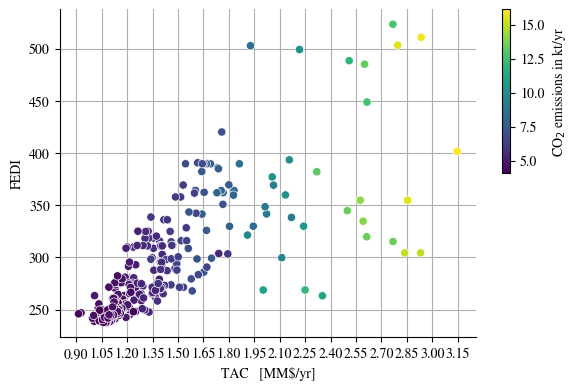

In [66]:
df = pd.read_csv('results_conventional_all.csv')
df = df[df['x2'] > 0.65*1.1] # Eliminar puntos al aplicar filtro de reflujo
df = df[df['x1'] < 50]       # Eliminar columnas que son muy grandes
plot_function(df, Fedi = 'FEDI2', filtrated = True)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, '$TAC$'),
  Text(1.5, 0, '$Fedi_{Ext}$'),
  Text(2.5, 0, '$Fedi_{Rec}$'),
  Text(3.5, 0, '$CO_{2}$'),
  Text(4.5, 0, '$NT_{Ext}$'),
  Text(5.5, 0, '$R_{Ext}$'),
  Text(6.5, 0, '$NF_{solv}$'),
  Text(7.5, 0, '$NF_{azeo}$'),
  Text(8.5, 0, '$S/F$'),
  Text(9.5, 0, '$NT_{Rec}$'),
  Text(10.5, 0, '$R_{Rec}$'),
  Text(11.5, 0, '$NF_{B1}$')])

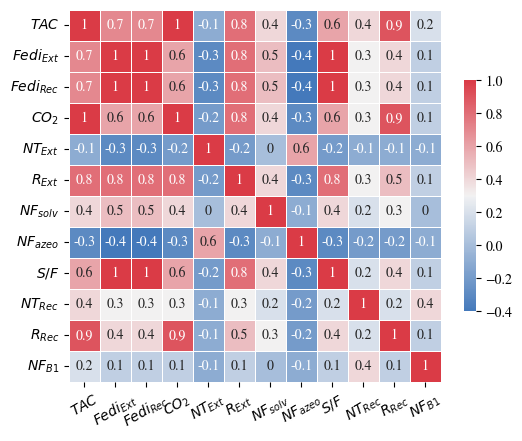

In [67]:
# Extract data 
plt.rcParams['font.family'] = 'STIXGeneral'
df = pd.read_csv('results_conventional_all.csv')
df = df.rename(columns={"TAC": '$TAC$', "FEDI1": "$Fedi_{Ext}$", "FEDI2": "$Fedi_{Rec}$", "CO2" : "$CO_{2}$", 
                "x1": "$NT_{Ext}$" , "x2": "$R_{Ext}$" , "x3": "$NF_{solv}$" , "x4": "$NF_{azeo}$" ,
                "x5": "$S/F$" , "x6": "$NT_{Rec}$" , "x7": "$R_{Rec}$" ,"x8": "$NF_{B1}$" })

df = df.drop(columns=['xd1' , 'xd2', 'xd3'])
corr_matrix = round(df.corr(),1)
#corr_matrix
f, ax = plt.subplots(figsize=(6,6))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap , center=None, square=True, annot=True ,linewidths=.5, cbar_kws={"shrink": 0.5})
plt.xticks(rotation=30)

In [68]:
df = pd.read_csv('results_conventional_all.csv')
df = df[df['x2'] > 0.65*1.1] # Eliminar puntos al aplicar filtro de reflujo
df = df[df['x1'] < 50]       # Eliminar columnas que son muy grandes
Features = ['TAC','FEDI1','FEDI2','CO2']
df_list = []
for i,c in enumerate(Features):
    pos = df[df[c]== df[c].min()].index
    df_list.append(df.loc[pos])
keys_names = ['min TAC','min FediB1', 'min FediB2','min CO2']
resultados = pd.concat(df_list, keys= keys_names )
resultados.to_csv('results_conventional_final.csv', index=False)  
resultados

,,TAC,FEDI1,FEDI2,CO2,x1,x2,x3,x4,x5,x6,x7,x8,xd1,xd2,xd3
min TAC,3495,0.913978,282.721577,245.869448,4.171693,46,1.274390,11,39,43.229007,40,0.164502,24,0.999200,0.999200,1.000000
min FediB1,2276,1.060787,276.261612,237.614972,4.191961,48,1.268900,4,40,38.560902,33,0.183545,19,0.999080,0.999080,0.999951
min FediB2,2276,1.060787,276.261612,237.614972,4.191961,48,1.268900,4,40,38.560902,33,0.183545,19,0.999080,0.999080,0.999951
min CO2,825,1.040800,277.027114,238.602104,4.054915,47,1.207646,4,40,39.103926,35,0.132250,25,0.999006,0.999006,0.999944


# NOW LETS RUN THE MULTIOBJECTIVE PROBLEM FOR THE INTENSIFIED DESIGN

In [ ]:

class IntensifiedSequence(ElementwiseProblem):
    
    def __init__(self,listofcomponents,FlashPoint_val,IgnitionTemperature_val, NF, NR, tags, tags_1 , c1_mole_frac, 
        c2_mole_frac, c3_mole_frac, **kwargs):
        #Column 1: Number stages,Reflux ratio,Feed stage1,Feed stage2, SolventFlow
        #Column 2: Number stages,Reflux ratio,Feed stage
        self.listofcomponents = listofcomponents
        self.FlashPoint_val = FlashPoint_val
        self.IgnitionTemperature_val = IgnitionTemperature_val
        self.NF = NF
        self.NR = NR
        self.tags = tags
        self.tags_1 = tags_1 
        self.c1_mole_frac = c1_mole_frac
        self.c2_mole_frac = c2_mole_frac
        self.c3_mole_frac = c3_mole_frac

        variables = dict()
        # ------------------Bounds----------------------#
        # First column
        Max_NT_C1, Max_NT_C2 = 50 , 50
        Max_Rr_C1 = 3.0
        variables[f"x1"] = Integer(bounds=(20,Max_NT_C1))      #Number stages of  DWC
        variables[f'x2'] = Real(bounds=(0.1,Max_Rr_C1))       #Reflux ratio extractive
        variables[f'x3'] = Real(bounds=(10,150))                #Solvent flow
        variables[f'x4'] = Integer(bounds=(2,Max_NT_C1))      #Feed stage solvent
        variables[f'x5'] = Integer(bounds=(2,Max_NT_C1))      #Feed stage azeotropic 
        # Cantidad de vapor que sale de la columna 1
        variables[f'x6'] = Real(bounds=(5,200))                #Vapor flow  [kmol/hr]
        # Second column
        variables[f'x7'] = Integer(bounds=(20,Max_NT_C2))     #Number of stage for rectifier
        # Global conditions
        Max_P = 2.0 
        variables[f'x8'] = Real(bounds=(0.8,Max_P))    #Pressure of both columns atm
        super().__init__(vars=variables, n_obj=3,n_ieq_constr=3, **kwargs)

    #-----------------------------------------------------#
    #  FUNCTIONS TO CALCULATE CAPITAL AND UTILITIES COST  #
    #-----------------------------------------------------#

    def Column(self, nt1,  ds , P, payback = 3,
        M_S = 1716,fm = 3.67, ft = 0):
        # Inputs
        # M_S : M&S is Marshall and Swift Equipment Cost Index year 2019
        # fm value for stainless steel
        # d : divided column diameter  in meters
        # nt : number of trays
        # ft : tray sieve
        # Variables
        # L : column length in meters  
        H = 1.2*0.61*(nt1-2)
        fp = 1 + 0.00074*(P - 3.48) + 0.00023*(P-3.48)**2
        fc = fm*fp
        CostColumn =  (M_S/280)*(957.9*(ds**1.066)*(H**0.802))*(2.18 + fc) 
        PlatosColumn =  (M_S/280)*(round(nt1))*97.2*(ds**1.55)*(ft + fm)
        TotalCost = (CostColumn + PlatosColumn)/payback   # [USD/yr]
        return TotalCost
    
    def CondenserColumn(self,COND_DUTY,TOP_TEMP, payback = 3, labour = 8000, M_S = 1716, \
        ktc =  0.852,fd = 0.8,fm =2.81,fp = 0 ):
        # Inputs
        # M_S : M&S is Marshall and Swift Equipment Cost Index year 2019
        # ktc : Heater-transfer coefficient  in kW/m2K
        # Fm  : carbon steel shell, stainless steel tube
        # Fd  : fixed tube sheet
        # Fp  : pressures lower than 10.3 bar 
        # --------------------------#
        # Accessing values of ASPEN #
        # --------------------------#
        Condenserduty = Application.Tree.FindNode(COND_DUTY).Value*0.0041868  # cal/sec to kW
        Tcond  = Application.Tree.FindNode(TOP_TEMP).Value + 273.15 #Kelvyn
        # --------------------------#
        CoolingService = [278, 310]  # [K] Chilled water, cooling water # 5 y 36.85°C
        Utilitiprice = [4.43, 0.354] # [$/GJ]
        # TcoolingSErvice < Tcond ...
        if CoolingService[1] < Tcond:  
            # Use cooling water
            Tcools = CoolingService[1]
            Uprice = Utilitiprice[1]
        elif CoolingService[0] < Tcond:
            # Use chilled water
            Tcools = CoolingService[0]
            Uprice = Utilitiprice[0]
        # ------------ #
        # Capital Cost #
        # ------------ #
        DeltaT_Condenser = Tcond - Tcools 
        AreaCondenser = abs(Condenserduty)/(ktc*(DeltaT_Condenser)) # [m2]
        fc = (fd+fp)*fm
        K = M_S*1.695*(2.29 + fc)
        CostCondenser = K*(AreaCondenser**0.65)
        # --------------- #
        # Utilititie Cost #
        # --------------- #     
        UtiCondenser = Uprice*abs(Condenserduty)*(1e-6)*labour*3600  # [$/year]        
        TotalCost = CostCondenser/payback + UtiCondenser  # [$/year]
        return TotalCost

    def ReboilerColumn(self,REB_DUTY,BOTTOM_TEMP, payback = 3, labour = 8000, M_S = 1716, \
        ktc =  0.568,fd =1.35,fm=2.81, fp = 0):
        # Inputs
        # BOTTOM_TEMP, REB_DUTY : direction of parameters in ASPEN 
        # payback, labour : payback period and labour hours
        # M_S : M&S is Marshall and Swift Equipment Cost Index year 2019
        # ktc : Heater-transfer coefficient  in kW/m2K
        # Fd  : fixed tube sheet
        # Fm  : carbon steel shell, stainless steel tube
        # Fp_bar  : pressure of condenser of 1 bar (default value)
        # --------------------------#
        # Accessing values of ASPEN #
        # --------------------------#
        Temp  = Application.Tree.FindNode(BOTTOM_TEMP).Value + 273.15 # Celsius to Kelvyn
        ReboilerDuty = Application.Tree.FindNode(REB_DUTY).Value*0.0041868    #cal/sec to kW
        ReboilerService = [433,457,527]  # Tempearture [K]
        Utilitiprice = [7.78,8.22,9.8]     # [$/GJ]
        #LatenHeatService = [2085.03,1998.55,1697.79] #KJ/Kg
        if Temp < ReboilerService[0]:       #Use low pressure steam 
            #L = LatenHeatService[0]
            Uprice = Utilitiprice[0]
            Treb = ReboilerService[0]
        elif Temp < ReboilerService[1]:     #Use medium pressure steam
            #L = LatenHeatService[1]
            Uprice = Utilitiprice[1]
            Treb = ReboilerService[1]
        elif Temp < ReboilerService[2]:     #Use high pressure steam
            #L = LatenHeatService[2]
            Uprice = Utilitiprice[2]
            Treb = ReboilerService[2]

        # ------------ #
        # Capital Cost #
        # ------------ #
        fc = (fd + fp)*fm
        DeltaT_Reboiler = Treb - Temp   # Steam temperature-base temperature
        AreaReboiler = ReboilerDuty/(DeltaT_Reboiler*ktc)
        K = M_S*1.695*(2.29 + fc)
        CostReboiler = K*(AreaReboiler**0.65)  #[$]
        # --------------- #
        # Utilititie Cost #
        # --------------- #
        UtiReboiler = Uprice*ReboilerDuty*(1e-6)*labour*3600  # [$/year]
        TotalCost = CostReboiler/payback + UtiReboiler  # [$/year]
        return TotalCost

    def Antoine_function(self,Antoine1,Antoine2,Antoine3,Antoine4,Antoine5,Antoine6,Antoine7,T):
        ListPsat = [] 
        for i in range(len(Antoine1)):
            ListPsat.append(np.exp(Antoine1[i] + Antoine2[i]/(T+Antoine3[i]) + Antoine4[i]*T + Antoine5[i]*np.log(T) +  Antoine6[i]*T**Antoine7[i]))
        return np.array(ListPsat)

    def Antoine_values(self, listofcomponents):
        # Parameters for vapor pressure (Extended Antoine)
        listofvalues = ['VAL1','VAL2','VAL3','VAL4','VAL5','VAL6','VAL7']  #Default values given in Aspen
        listA, listB, listC, listD, listE, listF, listG = [],[],[],[],[],[],[]
        for i in listofvalues:
            for j in listofcomponents:
                path_constants = r"\Data\Properties\Parameters\Pure Components\PLXANT-1\Input\{value}\PLXANT\{comp}".format(value= i, comp = j)
                if i == 'VAL1':
                    listA.append(float(Application.Tree.FindNode(path_constants).Value))
                elif i == 'VAL2':
                    listB.append(float(Application.Tree.FindNode(path_constants).Value))
                elif i == 'VAL3':
                    listC.append(float(Application.Tree.FindNode(path_constants).Value))
                elif i == 'VAL4':
                    listD.append(float(Application.Tree.FindNode(path_constants).Value))
                elif i == 'VAL5':
                    listE.append(float(Application.Tree.FindNode(path_constants).Value))
                elif i == 'VAL6':
                    listF.append(float(Application.Tree.FindNode(path_constants).Value))
                elif i == 'VAL7':
                    listG.append(float(Application.Tree.FindNode(path_constants).Value))  
        return listA, listB, listC, listD, listE, listF, listG

    def EnthalpyCombustion(self, listofcomponents):
        # Enthalpys of combustion from aspen in cal/mol
        listHcom = []
        for i in listofcomponents:
            dic = r"\Data\Properties\Parameters\Pure Components\REVIEW-1\Input\VALUE\HCOM\{comp}"
            Hcom  = float(Application.Tree.FindNode(dic.format(comp = i)).Value)/1000 #kcal/mol 
            Hcom = Hcom*4184  #J/mol
            listHcom.append(Hcom) 
        return  np.array(listHcom)

    def variables_FEDI(self,listofcomponents): #, nt1):
        x_in1 , x_in2 = [] , []
        Feed_1_dir = r"\Data\Streams\FEED\Input\FLOW\MIXED\{comp}"
        Feed_2_dir = r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\{comp}"
        for i in listofcomponents:
            # Extract molar composition information of stream 1
            if Application.Tree.FindNode(Feed_1_dir.format(comp = i)).Value == None:
                x_in1.append(0.00)
            else:
                x_in1.append(Application.Tree.FindNode(Feed_1_dir.format(comp = i)).Value)
            # Extract molar composition information of stream 2
            if Application.Tree.FindNode(Feed_2_dir.format(comp = i)).Value == None:
                x_in2.append(0.00)
            else:
                x_in2.append(Application.Tree.FindNode(Feed_2_dir.format(comp = i)).Value)  
        # Normalize the composition of both streams entering in the column 
        F1 = Application.Tree.FindNode(r"\Data\Streams\FEED\Input\TOTFLOW\MIXED").Value
        F2 = Application.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\TOTFLOW\MIXED").Value
        T_in_1 = Application.Tree.FindNode(r"\Data\Streams\5\Output\TEMP_OUT\MIXED").Value + 273.15 #[K]
        T_in_2 = Application.Tree.FindNode(r"\Data\Streams\3\Output\TEMP_OUT\MIXED").Value + 273.15 #[K]
        x_ins = ( ((np.array(F1)*np.array(x_in1)   +   np.array(F2)*np.array(x_in2)) / (F1+F2)) )
        #Mean Temperature between solvent and azeotropic mixture
        Ts = ((T_in_1+T_in_2)/2) 
        
        return x_ins,  Ts

    def Fedi(self, block_tag, listofcomponents, NF, NR, x_in, T, d, nt, FlashPoint_val, \
                IgnitionTemperature_val):
        # Enthalpys of combustion from aspen in cal/mol
        listHcom = self.EnthalpyCombustion(listofcomponents)
        # Parameters for vapor pressure (Extended Antoine)
        listA, listB, listC, listD, listE, listF, listG = self.Antoine_values(listofcomponents)
        
        # Calculations of FEDI for DWC column
        FlashPoint = sum(FlashPoint_val*x_in)
        AutoIgnitionTemp = sum(IgnitionTemperature_val*x_in)
        Vol = (np.pi * ( d/2)**2)*(1.2*0.61*(nt-2))  # [m3]
        Pcolumn = float(Application.Tree.FindNode(r"\Data\Blocks\{block}\Input\PRES1".format(block=block_tag)).Value*101.325)  # [atm a kPa]
        Mass =  float(Application.Tree.FindNode(r"\Data\Blocks\{block}\Output\BAL_MASI_TFL".format(block=block_tag)).Value/3600)  # [Kg/sec]
        Treb = Application.Tree.FindNode(r"\Data\Blocks\{block}\Output\BOTTOM_TEMP".format(block = block_tag)).Value + 273.15 # Celsius to Kelvyn
        #---------------F1,F2,F3,F4-----------------#
        Entalpy_comb = sum(abs(listHcom)*x_in )  # [cal/mol a J/mol]
        F1 = 0.1*(Mass*(Entalpy_comb))/3.148
        F2 = (6/3.148)*Pcolumn*Vol
        Psat_in = self.Antoine_function(listA,listB, listC, listD, listE, listF, listG, T)*100 # [Bar a kPa]
        VapPress = sum(Psat_in*x_in )
        F3 = (1e-3)*(1/Treb)*((Pcolumn-VapPress)**2)*Vol   # La temperatura es de la operación
        # Penalty 1
        if T > FlashPoint and T < 0.75*AutoIgnitionTemp: 
            pn1 = (1.45 +  1.75)/2
        elif T > 0.75*AutoIgnitionTemp:
            pn1 = 1.95
        else:
            pn1 = 1.1
        # Penalty 2
        if VapPress > 101.325 and Pcolumn > VapPress :
            pn2 = 1 + (Pcolumn-VapPress)*0.6/Pcolumn
            F = F2 + F3
        else:
            pn2 = 1 + (Pcolumn-VapPress)*0.4/Pcolumn
            F = F2
        if VapPress < 101.325 and 101.325 < Pcolumn:
            pn2 = 1 + (Pcolumn-VapPress)*0.2/Pcolumn
            F = F3
        else:
            pn2 = 1.1
            F = F3     
        # Penalty 4
        pn4 = 1 + 0.25*(np.array(NF).max() + np.array(NR).max())
        pn3,pn5,pn6 = 1,1,1
        Damage_Potential =  (F1*pn1 + F*pn2)*(pn3*pn4*pn5*pn6) 
        return  4.76*(Damage_Potential**(1/3)) 

    def CO2(self,tags, NHV = 39771 , C = 86.5, alfa = 3.67):
        CO2 = []
        for i in range(len(tags)):
            block_tag = tags[i]
            Temp  = Application.Tree.FindNode(r"\Data\Blocks\{block}\Output\BOTTOM_TEMP".format(block = block_tag)).Value + 273.15 # Celsius to Kelvyn
            ReboilerDuty = Application.Tree.FindNode(r"\Data\Blocks\{block}\Output\REB_DUTY".format(block = block_tag)).Value*0.0041868    #cal/sec to kW
            ReboilerService = [433,457,527]  # Tempearture [K]
            LatenHeatService = [2085.03,1998.55,1697.79]    #KJ/Kg
            EnthalpyService = [2758.65,2780.06,2802.23]     #KJ/Kg
            if Temp < ReboilerService[0]:       #Use low pressure steam 
                L = LatenHeatService[0]
                Enthalpy = EnthalpyService[0]
            elif Temp < ReboilerService[1]:     #Use medium pressure steam
                L = LatenHeatService[1]
                Enthalpy = EnthalpyService[1]
            elif Temp < ReboilerService[2]:     #Use high pressure steam
                L = LatenHeatService[2]
                Enthalpy = EnthalpyService[2]
            #The boiler feed water is assumed to be at 100 °C with an enthalpy of 419 kJ/kg
            Tftb = 1800 + 273.15    #[K]
            Tstack = 160 + 273.15   #[K]
            To = 25+273.15          #[K]
            efficiency = (Tftb - To)/(Tftb - Tstack)
            Q_Fuel = (ReboilerDuty/L)*(Enthalpy - 419)*efficiency
            CO2_val = (Q_Fuel/NHV)*(C/100)*alfa
            CO2.append(CO2_val) # [kg/s]
        return sum(np.array(CO2))*28.8   # [kt/yr]

    def constraints_eval(self, x):
        Constraint_List = []
        Constraint_List.append((x[0]-x[6]) > 2.0) # NT2 < NT1:  lets specify a separation of 4 stages 
        
        Constraint_List.append(x[3]<x[0]) #  Feed stage solvent < NT1 
        Constraint_List.append(x[4]<x[0]) #  Feed stage azeotropic < NT1 
        Constraint_List.append(x[3]<x[4]) # Feed stage solvent < Feed stage azeotropic 
        Constraint_List.append(x[3]<x[6]) # Feed stage solvent < NT2
        Constraint_List.append(x[4]<x[6]) # Feed stage azeotropic < NT2
        return Constraint_List

    def Update_Aspen(self,x):
        #-----------------------------Column 1-----------------------------#
        N_C1 = r"\Data\Blocks\B1\Input\NSTAGE"
        RR_C1  = r"\Data\Blocks\B1\Input\BASIS_RR"
        solvent_flow_rate = r"\Data\Streams\SOLVENT\Input\TOTFLOW\MIXED"
        FeedStage_1  = r"\Data\Blocks\B1\Input\FEED_STAGE\3"  
        FeedStage_2 = r"\Data\Blocks\B1\Input\FEED_STAGE\5"
        vapor_flow = r"\Data\Blocks\B1\Input\PROD_FLOW\VR"
        #Send to Aspen #
        Application.Tree.FindNode(N_C1).Value = x[0] 
        Application.Tree.FindNode(RR_C1).Value = x[1] 
        Application.Tree.FindNode(solvent_flow_rate).Value = x[2] 
        Application.Tree.FindNode(FeedStage_1).Value = x[3]   
        Application.Tree.FindNode(FeedStage_2).Value = x[4]
        Application.Tree.FindNode(vapor_flow).Value = x[5]
        # Internals of column 1
        B1_INT_1 = r"\Data\Blocks\B1\Subobjects\Column Internals\INT-1\Input\CA_STAGE2\INT-1\INT"
        Application.Tree.FindNode(B1_INT_1).Value = x[0] - 1  # Actualizar internals de primera columna


        #-----------------------------Column 2-----------------------------#
        N_C2 = r"\Data\Blocks\B2\Input\NSTAGE"
        #Send to Aspen #
        Application.Tree.FindNode(N_C2).Value = x[6] # Se alimenta en el fondo de la columna o NT2 
        vapor_source_stage  = r"\Data\Blocks\B1\Input\PROD_STAGE\VR"
        Application.Tree.FindNode(vapor_source_stage).Value = x[6]+1  # A stage below
        liquid_feedstage = r"\Data\Blocks\B1\Input\FEED_STAGE\S1"
        Application.Tree.FindNode(liquid_feedstage).Value = x[6]+1  # A stage below
        vapor_feedstage = r"\Data\Blocks\B2\Input\FEED_STAGE\VR"
        Application.Tree.FindNode(vapor_feedstage).Value = x[6]   # In the final stage
        liquid_product  = r"\Data\Blocks\B2\Input\PROD_STAGE\S1"
        Application.Tree.FindNode(liquid_product).Value = x[6]   # In the final stage
        # Internals of column 2
        B2_INT_1 = r"\Data\Blocks\B2\Subobjects\Column Internals\INT-1\Input\CA_STAGE2\INT-1\INT"
        Application.Tree.FindNode(B2_INT_1).Value = x[6]   # Actualizar internals de segunda columna


        # Update global parameters ( pressure )
        Application.Tree.FindNode(r"\Data\Blocks\B1\Input\PRES1").Value = round(x[7],2)
        Application.Tree.FindNode(r"\Data\Blocks\B2\Input\PRES1").Value = round(x[7],2)
        Application.Tree.FindNode(r"\Data\Blocks\EXC1\Input\PRES").Value = round(x[7],2)
        Application.Tree.FindNode(r"\Data\Blocks\EXC2\Input\PRES").Value = round(x[7],2)
        # estos no aplican por que esta todo en un solo equipo....
        #Application.Tree.FindNode(r"\Data\Blocks\P1\Input\P_OUT").Value = round(x[7],2)
        #Application.Tree.FindNode(r"\Data\Blocks\P2\Input\PRES").Value = round(x[7],2)
        #Application.Tree.FindNode(r"\Data\Blocks\P3\Input\PRES").Value = round(x[7],2)
        #Application.Tree.FindNode(r"\Data\Blocks\P4\Input\PRES").Value = round(x[7],2)
        #Application.Tree.FindNode(r"\Data\Blocks\P5\Input\PRES").Value = round(x[7],2)
        #Application.Tree.FindNode(r"\Data\Blocks\P6\Input\PRES").Value = round(x[7],2)
        #Application.Tree.FindNode(r"\Data\Blocks\MIX1\Input\PRES").Value =  x[7]

    def Clean_Aspen(self):
        #-----------------------------Column 1-----------------------------#
        N_C1 = r"\Data\Blocks\B1\Input\NSTAGE"
        RR_C1  = r"\Data\Blocks\B1\Input\BASIS_RR"
        solvent_flow_rate = r"\Data\Streams\SOLVENT\Input\TOTFLOW\MIXED"
        FeedStage_1  = r"\Data\Blocks\B1\Input\FEED_STAGE\3"  
        FeedStage_2 = r"\Data\Blocks\B1\Input\FEED_STAGE\5"
        vapor_flow = r"\Data\Blocks\B1\Input\PROD_FLOW\VR"
        #Send to Aspen #
        Application.Tree.FindNode(N_C1).Value = 60
        #Application.Tree.FindNode(RR_C1).Value = x[1] 
        #Application.Tree.FindNode(solvent_flow_rate).Value = x[2] 
        Application.Tree.FindNode(FeedStage_1).Value = 1  
        Application.Tree.FindNode(FeedStage_2).Value = 2
        #Application.Tree.FindNode(vapor_flow).Value = x[5]
        # Internals of column 1
        B1_INT_1 = r"\Data\Blocks\B1\Subobjects\Column Internals\INT-1\Input\CA_STAGE2\INT-1\INT"
        Application.Tree.FindNode(B1_INT_1).Value = 60 - 1  # Actualizar internals de primera columna


        #-----------------------------Column 2-----------------------------#
        N_C2 = r"\Data\Blocks\B2\Input\NSTAGE"
        #Send to Aspen #
        Application.Tree.FindNode(N_C2).Value = 30 # Se alimenta en el fondo de la columna o NT2 
        vapor_source_stage  = r"\Data\Blocks\B1\Input\PROD_STAGE\VR"
        Application.Tree.FindNode(vapor_source_stage).Value = 30+1  # A stage below
        liquid_feedstage = r"\Data\Blocks\B1\Input\FEED_STAGE\S1"
        Application.Tree.FindNode(liquid_feedstage).Value = 30+1  # A stage below
        vapor_feedstage = r"\Data\Blocks\B2\Input\FEED_STAGE\VR"
        Application.Tree.FindNode(vapor_feedstage).Value = 30   # In the final stage
        liquid_product  = r"\Data\Blocks\B2\Input\PROD_STAGE\S1"
        Application.Tree.FindNode(liquid_product).Value = 30   # In the final stage
        # Internals of column 2
        B2_INT_1 = r"\Data\Blocks\B2\Subobjects\Column Internals\INT-1\Input\CA_STAGE2\INT-1\INT"
        Application.Tree.FindNode(B2_INT_1).Value = 30   # Actualizar internals de segunda columna

    def Error_Run(self):
        return 1000000, 0.00001, 0.00001, 0.00001, 1000000, 1000000

    def B1_Check(self,listofcomponents, nt1 ):
        x_in_check = []
        for i in listofcomponents:
            x_in_check.append(Application.Tree.FindNode(r"\Data\Blocks\B1\Output\X\{nts}\{comp}".format(nts = str(int(nt1)), comp = str(i) )) == None)
        return x_in_check

    def B2_Check(self,listofcomponents, nt2 ):
        x_in_check = []
        for i in listofcomponents:
            x_in_check.append(Application.Tree.FindNode(r"\Data\Blocks\B2\Output\X\{nts}\{comp}".format(nts = str(int(nt2)), comp = str(i) )) == None)
        return x_in_check

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array([x[f"x{k:01}"] for k in range(1,9)])
        #----------Constraints function----------#
        cnst = self.constraints_eval(x)
        if all(cnst) == True : 
            self.Clean_Aspen()
            self.Update_Aspen(x)
            #-Run problem -#
            Application.Engine.Run2()
            Run_Status = 0
            Run_Status_Dir = r"\Data\Results Summary\Run-Status\Output\UOSSTAT2"
            #First Check if Status return a value
            if Application.Tree.FindNode(Run_Status_Dir) == None:  # This means there was a problem
                TAC,XD1, XD2, XD3, Fedi, CO2_process = self.Error_Run()
            else: # Get the current status of the simulation
                Run_Status = Application.Tree.FindNode(Run_Status_Dir).Value
                B1Check= self.B1_Check(self.listofcomponents,x[0])
                B2Check= self.B2_Check(self.listofcomponents,x[6])
                if Run_Status == 9 or all(B1Check) == True or all(B2Check) == True:
                    TAC,XD1, XD2,XD3, Fedi, CO2_process = self.Error_Run()
                    Application.Reinit()  # Restart the simulation and clean the errors
                else:   # Simulation without errors
                    #----------------#
                    #  Columna B1    #
                    #----------------#
                    nt1, nt2= x[0] ,x[6]       # Value of number of stages   
                    d1 = Application.Tree.FindNode(r"\Data\Blocks\B1\Subobjects\Column Internals\INT-1\Subobjects\Sections\INT\Input\CA_DIAM\INT-1\INT").Value
                    d2 = Application.Tree.FindNode(r"\Data\Blocks\B2\Subobjects\Column Internals\INT-1\Subobjects\Sections\INT\Input\CA_DIAM\INT-1\INT").Value
                    P1 = Application.Tree.FindNode(r"\Data\Blocks\B1\Input\PRES1").Value * 1.01325    # atm a bars
                    CostColumn = self.Column(nt1=nt1,ds = max(d1,d2) , P = P1 )  # [USD/Yr]
                    #----------------#
                    # CONDENSADOR B1 #
                    #----------------#
                    COND_DUTY = r"\Data\Blocks\B1\Output\COND_DUTY"
                    TOP_TEMP = r"\Data\Blocks\B1\Output\TOP_TEMP"
                    CostCondenser = self.CondenserColumn(COND_DUTY,TOP_TEMP) # [USD/Yr]
                    #--------------#
                    # REBOILER  B1 #
                    #--------------#
                    REB_DUTY = r"\Data\Blocks\B1\Output\REB_DUTY"
                    BOTTOM_TEMP = r"\Data\Blocks\B1\Output\BOTTOM_TEMP"
                    CostReboiler = self.ReboilerColumn(REB_DUTY,BOTTOM_TEMP) # [USD/Yr]
                    TAC1  = (CostColumn + CostCondenser +  CostReboiler)/1e6  
                    #----------------#
                    # Rectificador B2#
                    # CONDENSER   B2 #
                    #----------------#
                    COND_DUTY = r"\Data\Blocks\B2\Output\COND_DUTY"
                    TOP_TEMP = r"\Data\Blocks\B2\Output\TOP_TEMP"
                    CostCondenser = self.CondenserColumn(COND_DUTY,TOP_TEMP) # [USD/Yr]
                    TAC2  = (CostCondenser)/1e6  
                    TAC = TAC1 + TAC2
                    #------- Fedis  Blocks-----------#
                    x_ins, Ts = self.variables_FEDI(self.listofcomponents)
                    Fedi = self.Fedi('B1', self.listofcomponents, self.NF, self.NR, x_ins, Ts, max(d1,d2), nt1, self.FlashPoint_val, self.IgnitionTemperature_val)
                    #------------ CO2 --------------#
                    CO2_process = self.CO2(['B1'])
                    #------------ Constraints------------#
                    # Get the information of purities in the distillates from intensified column
                    XD1  = Application.Tree.FindNode(self.c1_mole_frac).Value
                    XD2  = Application.Tree.FindNode(self.c2_mole_frac).Value 
                    XD3  = Application.Tree.FindNode(self.c3_mole_frac).Value
        else:
            # Unfeasible desing
            TAC,XD1, XD2, XD3, Fedi, CO2_process  = self.Error_Run()
        out["F"] = [TAC, Fedi, CO2_process]                #Declare the functions
        out["G"] = [(-XD1 + 0.9990),(-XD2 + 0.9990),(-XD3 + 0.9990)]    #Declare the constraints (purity)


In [ ]:
class objective_intensified():
    
    def __init__(self, funtion_val, number_pd):
        self.funtion_val = funtion_val
        self.number_pd = number_pd

    def save_df(self,res):
        # Extract best results 
        sol, fun, const = [], [], []
        for i, c in enumerate(res.history):
            sol.extend(c.opt.get("F"))
            fun.extend(c.opt.get("X"))
            const.extend(-c.opt.get("G")+0.9990)
        df1 = pd.DataFrame(data=sol , columns=['TAC', 'FEDI', 'CO2'])
        df2 = pd.DataFrame(data=fun )
        df3 = pd.DataFrame(data=const, columns=['xd1', 'xd2', 'xd3'])
        df =pd.concat([df1,df2,df3], axis= 1)
        filtered_values = np.where((df['TAC']<10) & (df['xd1']>0.9990) & (df['xd2']>0.9990) & (df['xd3']>0.9990) )
        df = df.loc[filtered_values]
        df = df.drop_duplicates()
        df.to_csv(r'results_intensified_run{number}.csv'.format(number=self.number_pd+1), index=False)  
        return df

    def __call__(self, trial):
        # Hyperparameters to be optimized
        gen = trial.suggest_int('#gen', 60, 110) 
        pop = trial.suggest_int('#pop', 150, 350) 
        ofs = trial.suggest_int('#ofs', 40, 75)
        # Load data problem
        listofcomponents = ['METHA-01','DICHL-01','N:N-D-01']
        FlashPoint_val = np.array([9 , -4 , 58]) +273.15                 # [K] 
        IgnitionTemperature_val = np.array([ 464, 605, 440]) + 273.15   # [K]
        NF, NR = np.array([3,1,2]),np.array([0,0,0])    #NFPA values
        c1_mole_frac = r"\Data\Streams\DCM\Output\MOLEFRAC\MIXED\DICHL-01"
        c2_mole_frac = r"\Data\Streams\MEOH\Output\MOLEFRAC\MIXED\METHA-01"
        c3_mole_frac = r"\Data\Streams\DMF\Output\MOLEFRAC\MIXED\N:N-D-01"
        # Create problem
        problem = IntensifiedSequence(listofcomponents,FlashPoint_val,IgnitionTemperature_val, NF, NR,
                    c1_mole_frac,c2_mole_frac,c3_mole_frac )
        # Define the number of generations 
        termination = get_termination("n_gen", gen)
        algorithm = NSGA2(pop_size=pop, n_offsprings=ofs, sampling=MixedVariableSampling(),
                        mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                        eliminate_duplicates=MixedVariableDuplicateElimination())
        res = minimize(problem,algorithm,termination,seed=42,save_history=True,verbose=False)
        df = self.save_df(res)
        return  df.iloc[:,self.funtion_val].min()  # return minimum value encountered


In [ ]:
study_name = 'NSGAII_intensified'
storage_traj = f'sqlite:///{study_name}.db'
study_intensified = optuna.create_study(direction='minimize', study_name=study_name, storage=storage_traj, load_if_exists=True)

In [ ]:
#optuna.delete_study(study_name=study_name, storage=storage_traj)

In [ ]:
ciclos = 10
val_function = 0 # TAC position
for i in  tqdm(range(ciclos)):        
    file = 'Caso estudio intensificado.bkp'
    aspen_Path = os.path.abspath(file)
    Application = win32.Dispatch('Apwn.Document')
    Application.InitFromArchive2(aspen_Path)
    Application.Visible  = False
    Application.SuppressDialogs = True
    study_intensified.optimize(objective_intensified(funtion_val=val_function, number_pd= i), n_trials= 1)
    Application.Quit(aspen_Path)  
# Best hyperparameters
print(study.best_params)

[I 2024-10-30 10:07:13,290] Trial 0 finished with value: 0.7605198054601994 and parameters: {'#gen': 76, '#pop': 288, '#ofs': 70}. Best is trial 0 with value: 0.7605198054601994.\
[I 2024-10-30 12:34:33,446] Trial 1 finished with value: 0.8410422645301351 and parameters: {'#gen': 95, '#pop': 341, '#ofs': 47}. Best is trial 0 with value: 0.7605198054601994.\
[I 2024-10-30 16:24:42,281] Trial 2 finished with value: 0.773871400887103 and parameters: {'#gen': 81, '#pop': 159, '#ofs': 63}. Best is trial 0 with value: 0.7605198054601994.\
[I 2024-10-30 19:02:08,278] Trial 3 finished with value: 0.8161417954738573 and parameters: {'#gen': 108, '#pop': 342, '#ofs': 43}. Best is trial 0 with value: 0.7605198054601994.\
[I 2024-10-30 21:34:48,306] Trial 4 finished with value: 0.8516914158874455 and parameters: {'#gen': 82, '#pop': 319, '#ofs': 54}. Best is trial 0 with value: 0.7605198054601994.\
[I 2024-10-31 00:16:02,677] Trial 5 finished with value: 0.7754111293910955 and parameters: {'#gen': 99, '#pop': 291, '#ofs': 49}. Best is trial 0 with value: 0.7605198054601994.\
[I 2024-10-31 03:44:29,486] Trial 6 finished with value: 0.7217720858710022 and parameters: {'#gen': 72, '#pop': 166, '#ofs': 62}. Best is trial 6 with value: 0.7217720858710022.\
[I 2024-10-31 06:03:56,279] Trial 7 finished with value: 0.8365997976148942 and parameters: {'#gen': 76, '#pop': 291, '#ofs': 56}. Best is trial 6 with value: 0.7217720858710022.\
[I 2024-10-31 07:14:01,203] Trial 8 finished with value: 0.9329884654337536 and parameters: {'#gen': 62, '#pop': 289, '#ofs': 45}. Best is trial 6 with value: 0.7217720858710022.\
[I 2024-10-31 12:11:04,656] Trial 9 finished with value: 0.761811402494096 and parameters: {'#gen': 99, '#pop': 161, '#ofs': 57}. Best is trial 6 with value: 0.7217720858710022.\
{#gen': 72, '#pop': 166, '#ofs': 62}

In [ ]:
# Join all saved results in one single pandas dataframe
ciclos = 10
dfnew = pd.DataFrame()  # Empty dataframe
for i in range(ciclos):
    df = pd.read_csv(r'results_intensified_run{number}.csv'.format(number = i+1))
    dfnew = pd.concat([dfnew,df],axis=0, ignore_index = True) 
dfnew = dfnew.drop_duplicates()
dfnew.to_csv('results_intensified_all.csv', index=False)  
plot_function(dfnew, Fedi = 'FEDI', filtrated = True)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0.5, 0, '$TAC$'),
  Text(1.5, 0, '$Fedi_{DWC}$'),
  Text(2.5, 0, '$CO_{2}$'),
  Text(3.5, 0, '$NT_{DWC}$'),
  Text(4.5, 0, '$R_{DWC}$'),
  Text(5.5, 0, '$S/F$'),
  Text(6.5, 0, '$NF_{solv}$'),
  Text(7.5, 0, '$NF_{azeo}$'),
  Text(8.5, 0, '$V_{r}$'),
  Text(9.5, 0, '$DW_{Size}$'),
  Text(10.5, 0, '$P_{sys}$')])

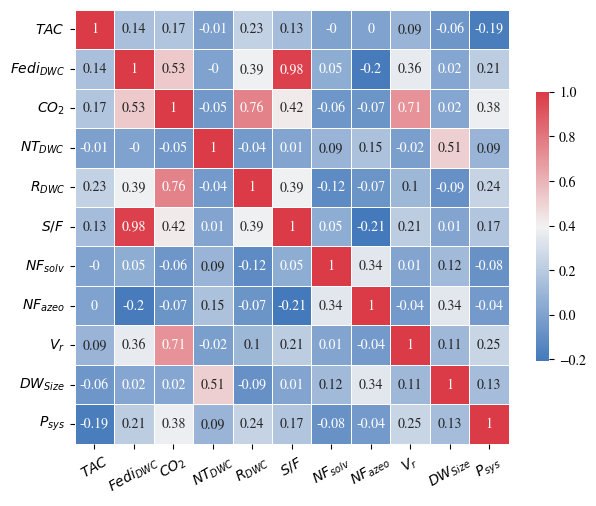

In [69]:
# Extract data 
#sns.set(font="STIXGeneral")
plt.rcParams['font.family'] = 'STIXGeneral'
df = pd.read_csv('results_intensified_all.csv')
df = df.rename(columns={"TAC": '$TAC$', "FEDI": "$Fedi_{DWC}$", "CO2" : "$CO_{2}$", 
                "x1": "$NT_{DWC}$" , "x2": "$R_{DWC}$" ,  "x3": "$S/F$" , "x4": "$NF_{solv}$" , "x5": "$NF_{azeo}$" ,
                "x6": "$V_{r}$" , "x7": "$DW_{Size}$" , "x8": "$P_{sys}$"  })

df = df.drop(columns=['xd1' , 'xd2', 'xd3'])
corr_matrix = round(df.corr(),2)
#corr_matrix
f, ax = plt.subplots(figsize=(7,7))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap , center=None, square=True, annot=True ,linewidths=.5, cbar_kws={"shrink": 0.5})
plt.yticks(rotation=0)
plt.xticks(rotation=30)

In [70]:
df = pd.read_csv('results_intensified_all.csv')
Features = ['TAC','FEDI','CO2']
df_list = []
for i,c in enumerate(Features):
    pos = df[df[c]== df[c].min()].index
    df_list.append(df.loc[pos])

keys_names =['min TAC','min Fedi','min CO2']
resultados = pd.concat(df_list, keys= keys_names )
resultados.to_csv('results_intensified_final.csv', index=False)  
resultados

,,TAC,FEDI,CO2,x1,x2,x3,x4,x5,x6,x7,x8,xd1,xd2,xd3
min TAC,4417,0.721772,258.791210,3.748713,44,0.815896,25.439634,6,23,55.950677,37,1.299809,0.999924,0.999924,0.999850
min Fedi,4383,0.806062,236.169917,3.489955,45,0.688624,12.483106,8,19,55.986740,38,0.858858,0.999555,0.999555,0.999930
min CO2,4418,0.904870,260.527730,3.465236,45,0.720539,26.791166,5,18,54.667831,39,1.039357,0.999664,0.999664,0.999375
